<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# [3주차] 기본과제: DistilBERT로 뉴스 기사 분류 모델 학습하기


In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] truncation 제거

In [3]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, max_length=max_len).input_ids) # truncation 제거했으나 확인 필요
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## [MY CODE] EDA

데이터셋 구조:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

학습 데이터 예시:
{'text': ["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums."], 'label': [2, 2, 2]}

레이블 분포:
Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})

텍스트 길이 통계:
평균 길이: 37.85
최대 길이: 17

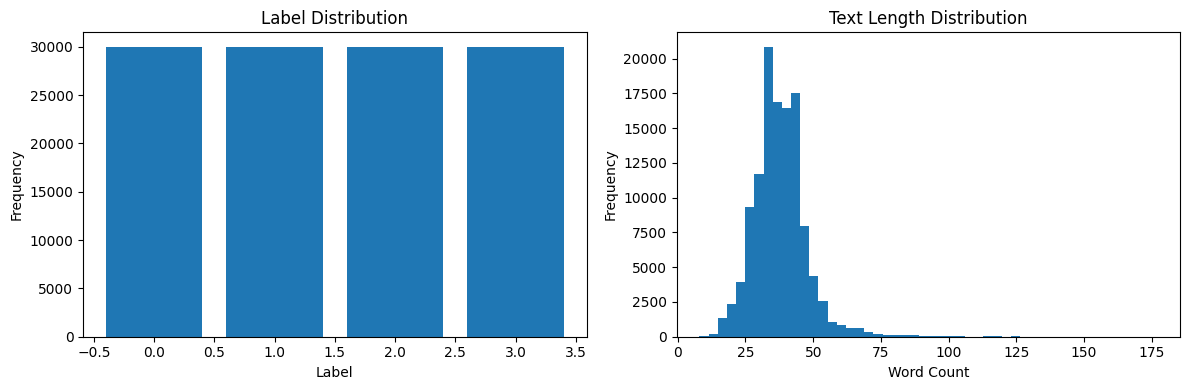

In [4]:
# 데이터셋 구조 확인
print("데이터셋 구조:")
print(ds)

# 학습 데이터 샘플 확인
print("\n학습 데이터 예시:")
print(ds['train'][:3])

# 레이블 분포 확인
from collections import Counter
labels = [example['label'] for example in ds['train']]
label_dist = Counter(labels)
print("\n레이블 분포:")
print(label_dist)

# 텍스트 길이 분석
text_lengths = [len(example['text'].split()) for example in ds['train']]
print("\n텍스트 길이 통계:")
print(f"평균 길이: {sum(text_lengths)/len(text_lengths):.2f}")
print(f"최대 길이: {max(text_lengths)}")
print(f"최소 길이: {min(text_lengths)}")

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 레이블 분포 시각화
plt.subplot(1, 2, 1)
plt.bar(label_dist.keys(), label_dist.values())
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# 텍스트 길이 분포 시각화
plt.subplot(1, 2, 2)
plt.hist(text_lengths, bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


토큰 길이 통계:
평균 토큰 길이: 53.17
최대 토큰 길이: 379
최소 토큰 길이: 15


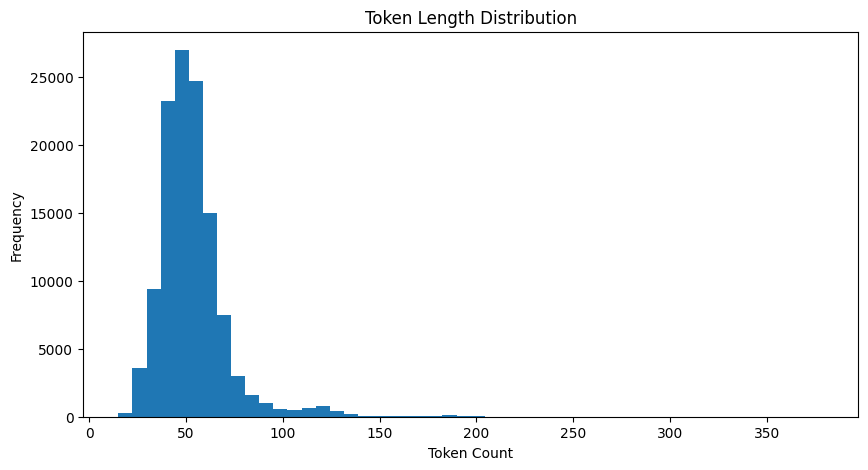

50번째 백분위수: 51
75번째 백분위수: 59
90번째 백분위수: 70
95번째 백분위수: 82
99번째 백분위수: 124

예시 텍스트 토큰화 결과:
원문: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
토큰: ['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short', '-', 'sellers', ',', 'wall', 'street', "'", 's', 'd', '##wind', '##ling', '\\', 'band', 'of', 'ultra', '-', 'cy', '##nic', '##s', ',', 'are', 'seeing', 'green', 'again', '.']
토큰 수: 39


In [5]:
# 토큰 길이 분석
token_lengths = []
for example in ds['train']:
    tokens = tokenizer.encode(example['text'])
    token_lengths.append(len(tokens))

# 토큰 길이 통계
print("\n토큰 길이 통계:")
print(f"평균 토큰 길이: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"최대 토큰 길이: {max(token_lengths)}")
print(f"최소 토큰 길이: {min(token_lengths)}")

# 토큰 길이 분포 시각화
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# 토큰 길이 백분위수 확인
import numpy as np
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}번째 백분위수: {np.percentile(token_lengths, p):.0f}")

# 예시 텍스트의 토큰화 결과 확인
sample_text = ds['train'][0]['text']
tokens = tokenizer.tokenize(sample_text)
print("\n예시 텍스트 토큰화 결과:")
print(f"원문: {sample_text}")
print(f"토큰: {tokens}")
print(f"토큰 수: {len(tokens)}")

In [6]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

## [MY CODE] classfier의 output dimension 조정

In [7]:
from torch import nn


class NewsClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, 0])

    return x


model = NewsClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

## [MY CODE] CrossEntropyLoss 사용

In [10]:
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

Epoch   0 | Train Loss: 881.8482840433717
Epoch   1 | Train Loss: 701.6952527463436
Epoch   2 | Train Loss: 674.8752826824784
Epoch   3 | Train Loss: 662.3963352069259
Epoch   4 | Train Loss: 652.6867358013988
Epoch   5 | Train Loss: 645.8576262891293
Epoch   6 | Train Loss: 643.6819576248527
Epoch   7 | Train Loss: 641.9550419822335
Epoch   8 | Train Loss: 637.3685333058238
Epoch   9 | Train Loss: 635.3772821500897


## [MY CODE] 분류문제에 맞게 argmax 적용

In [11]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.893 | Test acc: 0.888


## [LOG] 테스트 정확도 88.8%